In [25]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [24]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_all = concat_df(df_train, df_test)

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## **EDA**

In [26]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
520,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,S
303,304,1,2,"Keane, Miss. Nora A",female,NaN,0,0,226593,12.3500,E101,Q


In [27]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
325,1217,3,"Assam, Mr. Ali",male,23.0,0,0,SOTON/O.Q. 3101309,7.050,NaN,S
302,1194,2,"Phillips, Mr. Escott Robert",male,43.0,0,1,S.O./P.P. 2,21.000,NaN,S
259,1151,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.775,NaN,S


### **1.2 Missing Values**

In [32]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} - {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{DF}')
    display_missing(df)

{DF}
PassengerId - 0
Survived - 0
Pclass - 0
Name - 0
Sex - 0
Age - 177
SibSp - 0
Parch - 0
Ticket - 0
Fare - 0
Cabin - 687
Embarked - 2


{DF}
PassengerId - 0
Pclass - 0
Name - 0
Sex - 0
Age - 86
SibSp - 0
Parch - 0
Ticket - 0
Fare - 1
Cabin - 327
Embarked - 0




In [33]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [35]:
# df_all_corr

#### **Feature Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** It is also more logical to group ages by passenger classes instead of other features.

In [36]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Class {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Class 1 females: 36.0
Median age of Class 1 males: 42.0
Median age of Class 2 females: 28.0
Median age of Class 2 males: 29.5
Median age of Class 3 females: 22.0
Median age of Class 3 males: 25.0
Median age of all passengers: 28.0


In [37]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


#### **Feature Embarked**
There are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number.

In [38]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [39]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


#### **Feature Fare**
Only one missing value. Fare is related to family size (`Parch` and `SibSp`) and `Pclass` features.

In [40]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### **Feature Cabin**

In [42]:
df_all['Cabin'] = df_all['Cabin'].fillna('Missing')
df_all['Cabin'] = df_all['Cabin'].str[0]
df_all['Cabin'].value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [45]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age - 0
Cabin - 0
Embarked - 0
Fare - 0
Name - 0
Parch - 0
PassengerId - 0
Pclass - 0
Sex - 0
SibSp - 0
Survived - 0
Ticket - 0


Age - 0
Cabin - 0
Embarked - 0
Fare - 0
Name - 0
Parch - 0
PassengerId - 0
Pclass - 0
Sex - 0
SibSp - 0
Ticket - 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


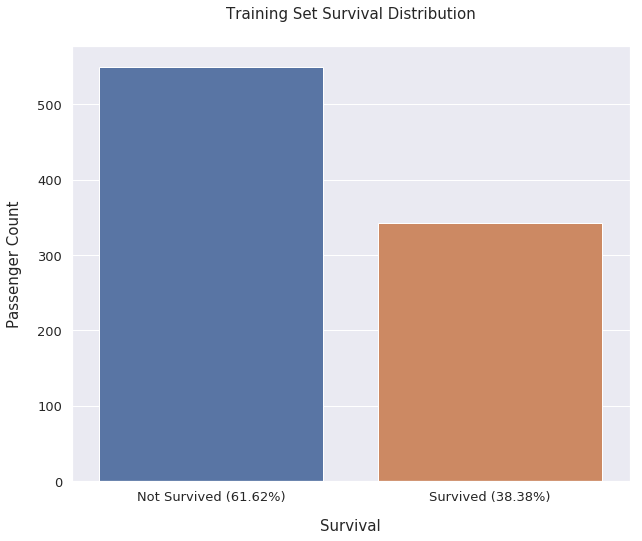

In [46]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [52]:
df_all = df_all.drop(['Name', 'Ticket'], axis = 1)

df_all.loc[ df_all['Age'] <= 16, 'Age'] = 0
df_all.loc[(df_all['Age'] > 16) & (df_all['Age'] <= 32), 'Age'] = 1
df_all.loc[(df_all['Age'] > 32) & (df_all['Age'] <= 48), 'Age'] = 2
df_all.loc[(df_all['Age'] > 48) & (df_all['Age'] <= 64), 'Age'] = 3
df_all.loc[ df_all['Age'] > 64, 'Age'] = 4 

In [55]:
df_dummies = pd.get_dummies(df_all, drop_first = True)
df_dummies.head()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S,Sex_male
0,1.0,7.2500,0,1,3,1,0.0,0,0,0,0,0,0,1,0,0,1,1
1,2.0,71.2833,0,2,1,1,1.0,0,1,0,0,0,0,0,0,0,0,0
2,1.0,7.9250,0,3,3,0,1.0,0,0,0,0,0,0,1,0,0,1,0
3,2.0,53.1000,0,4,1,1,1.0,0,1,0,0,0,0,0,0,0,1,0
4,2.0,8.0500,0,5,3,0,0.0,0,0,0,0,0,0,1,0,0,1,1


In [58]:
all_train = df_dummies[df_dummies['Survived'].notna()]
all_test = df_dummies[df_dummies['Survived'].isna()]

In [68]:
df_train, df_test = divide_df(df_dummies)
df_train.shape

(891, 18)

## **Model**

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_train.drop(['PassengerId','Survived'],axis=1), 
                                                    all_train['Survived'], test_size=0.30, 
                                                    random_state=101, stratify = all_train['Survived'])

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [72]:
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100, random_state=0)
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=0)

In [73]:
predictions = ada.predict(X_test)

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.77      0.85      0.80       165
         1.0       0.71      0.58      0.64       103

   micro avg       0.75      0.75      0.75       268
   macro avg       0.74      0.72      0.72       268
weighted avg       0.74      0.75      0.74       268



In [75]:
print (f'Train Accuracy - : {ada.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {ada.score(X_test,y_test):.3f}')

Train Accuracy - : 0.961
Test Accuracy - : 0.746


In [84]:
X_train = StandardScaler().fit_transform(df_train.drop(['PassengerId','Survived'],axis=1))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(['PassengerId'],axis=1))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 16)
y_train shape: (891,)
X_test shape: (418, 16)


In [85]:
rf_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)


In [87]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=1, warm_start=False)

In [88]:
trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train, rf_model.predict_proba(X_train)[:, 1])
trn_auc_score = auc(trn_fpr, trn_tpr)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1100 out of 1100 | elapsed:    0.6s finished


In [89]:
trn_auc_score

0.890087239957818